In [1]:
# import libraries

from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error, mean_squared_log_error, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression, LassoLarsCV
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
import xgboost as xgb
from xgboost.sklearn import XGBRegressor
from sklearn.model_selection import GridSearchCV, cross_val_score, KFold
from scipy.stats import pearsonr
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline

import pandas as pd
import numpy as np

import math
import time

# Pandas warning messages (optional)
pd.options.mode.chained_assignment = None  #default='warn'

# Plot options
import matplotlib.pyplot as plt
import seaborn as sns
sns.palplot(sns.color_palette('deep'))
sns.set_style("whitegrid")
%matplotlib inline

sns.set()

# I want crisp graphics, so we'll output SVG
#%config InlineBackend.figure_format = 'svg'

In [2]:
# Load data
df_cleaned = pd.read_csv('data/listings_cleaned.csv', low_memory=False)
df_cleaned.head()

id  price  latitude  longitude property_type        room_type  \
0  2265  225.0  30.27750  -97.71398         House  Entire home/apt   
1  5245  100.0  30.27577  -97.71379         House     Private room   
2  5456   95.0  30.26112  -97.73448    Guesthouse  Entire home/apt   
3  5769   40.0  30.45697  -97.78422         House     Private room   
4  6413   99.0  30.24829  -97.73726    Guesthouse  Entire home/apt   

   accommodates  bathrooms  bedrooms  bed_type  ... instant_bookable  \
0             4        2.0       2.0  Real Bed  ...                f   
1             2        1.0       1.0  Real Bed  ...                f   
2             3        1.0       1.0  Real Bed  ...                f   
3             2        1.0       1.0  Real Bed  ...                f   
4             2        1.0       1.0  Real Bed  ...                t   

   is_business_travel_ready          cancellation_policy  host_is_superhost  \
0                         f  strict_14_with_grace_period                  t   
1                         f  strict_14_with_grace_period                  t   
2                         f  strict_14_with_grace_period                  t   
3                         f                     moderate                  t   
4                         f  strict_14_with_grace_period                  t   

                         listing_url cleaning_fee security_deposit  \
0  https://www.airbnb.com/rooms/2265        100.0            500.0   
1  https://www.airbnb.com/rooms/5245         75.0            500.0   
2  https://www.airbnb.com/rooms/5456          0.0            100.0   
3  https://www.airbnb.com/rooms/5769          0.0              0.0   
4  https://www.airbnb.com/rooms/6413         50.0              0.0   

  extra_people guests_included region  
0         30.0               4   East  
1         35.0               2   East  
2         45.0               2   East  
3          0.0               2  North  
4         25.0               2  South  

[5 rows x 25 columns]

In [3]:
# Create a list to include the names of columns we want to use
features_list = [
    'property_type',
    'room_type',
    'bathrooms',
    'bedrooms',
    'host_is_superhost',
    'region',
    'accommodates',
    'review_scores_rating',
    'number_of_reviews',
    'extra_people',
    'security_deposit',
    'cleaning_fee'
]


# Create features and price DFs for sklearn inputs
#df_cleaned = df_cleaned[df_cleaned.price < df_cleaned.price.quantile(.95)]
features = df_cleaned[features_list]   # 'X'
y = df_cleaned[['price']]           # 'y'
y.describe()

price
count  11541.000000
mean     257.855385
std      386.982116
min       16.000000
25%       80.000000
50%      136.000000
75%      285.000000
max     7500.000000

In [4]:
# Price distribution is skewed to the right due to remaining outliers. Using np.log() to 
# normalize the price distribution
log_y = np.log(y)
print(log_y.head(), y.head())
log_y.describe()

      price
0  5.416100
1  4.605170
2  4.553877
3  3.688879
4  4.595120    price
0  225.0
1  100.0
2   95.0
3   40.0
4   99.0


price
count  11541.000000
mean       5.045184
std        0.940177
min        2.772589
25%        4.382027
50%        4.912655
75%        5.652489
max        8.922658

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000025C2F67B588>]],
      dtype=object)

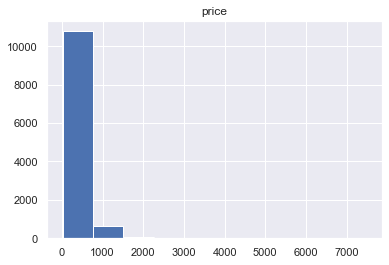

In [5]:
# Comparing price histogram with log(price) histogram
y.hist()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000025C2F77F0C8>]],
      dtype=object)

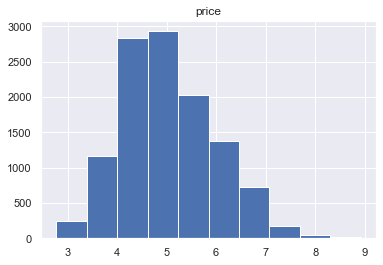

In [6]:
log_y.hist()

In [7]:
# Create dummy variables for categorical columns in the df
features = pd.get_dummies(features, drop_first=True)
features.head()

bathrooms  bedrooms  accommodates  review_scores_rating  number_of_reviews  \
0        2.0       2.0             4                  93.0                 24   
1        1.0       1.0             2                  91.0                  9   
2        1.0       1.0             3                  97.0                529   
3        1.0       1.0             2                  98.0                257   
4        1.0       1.0             2                  99.0                112   

   extra_people  security_deposit  cleaning_fee  property_type_Bungalow  \
0          30.0             500.0         100.0                       0   
1          35.0             500.0          75.0                       0   
2          45.0             100.0           0.0                       0   
3           0.0               0.0           0.0                       0   
4          25.0               0.0          50.0                       0   

   property_type_Condominium  ...  property_type_Serviced apartment  \
0                          0  ...                                 0   
1                          0  ...                                 0   
2                          0  ...                                 0   
3                          0  ...                                 0   
4                          0  ...                                 0   

   property_type_Townhouse  room_type_Hotel room  room_type_Private room  \
0                        0                     0                       0   
1                        0                     0                       1   
2                        0                     0                       0   
3                        0                     0                       1   
4                        0                     0                       0   

   room_type_Shared room  host_is_superhost_t  region_East  region_North  \
0                      0                    1            1             0   
1                      0                    1            1             0   
2                      0                    1            1             0   
3                      0                    1            0             1   
4                      0                    1            0             0   

   region_South  region_West  
0             0            0  
1             0            0  
2             0            0  
3             0            0  
4             1            0  

[5 rows x 25 columns]

In [8]:
# Using PCA for dimensionality-reduction
from sklearn.decomposition import PCA

# Set up PCA and the X vector for diminsionality reduction
pca = PCA(n_components=1)
df_X = features[[
    'bathrooms',
    'bedrooms',
    'accommodates',
    'extra_people',
    'security_deposit',
    'cleaning_fee',
    'review_scores_rating',
    'number_of_reviews',
]]

# Apply PCA to the dataset X vector
transformed_X = pca.fit_transform(df_X)

# Look at the percentage of variance explained by the different components
print(pca.explained_variance_ratio_)

[0.95625564]


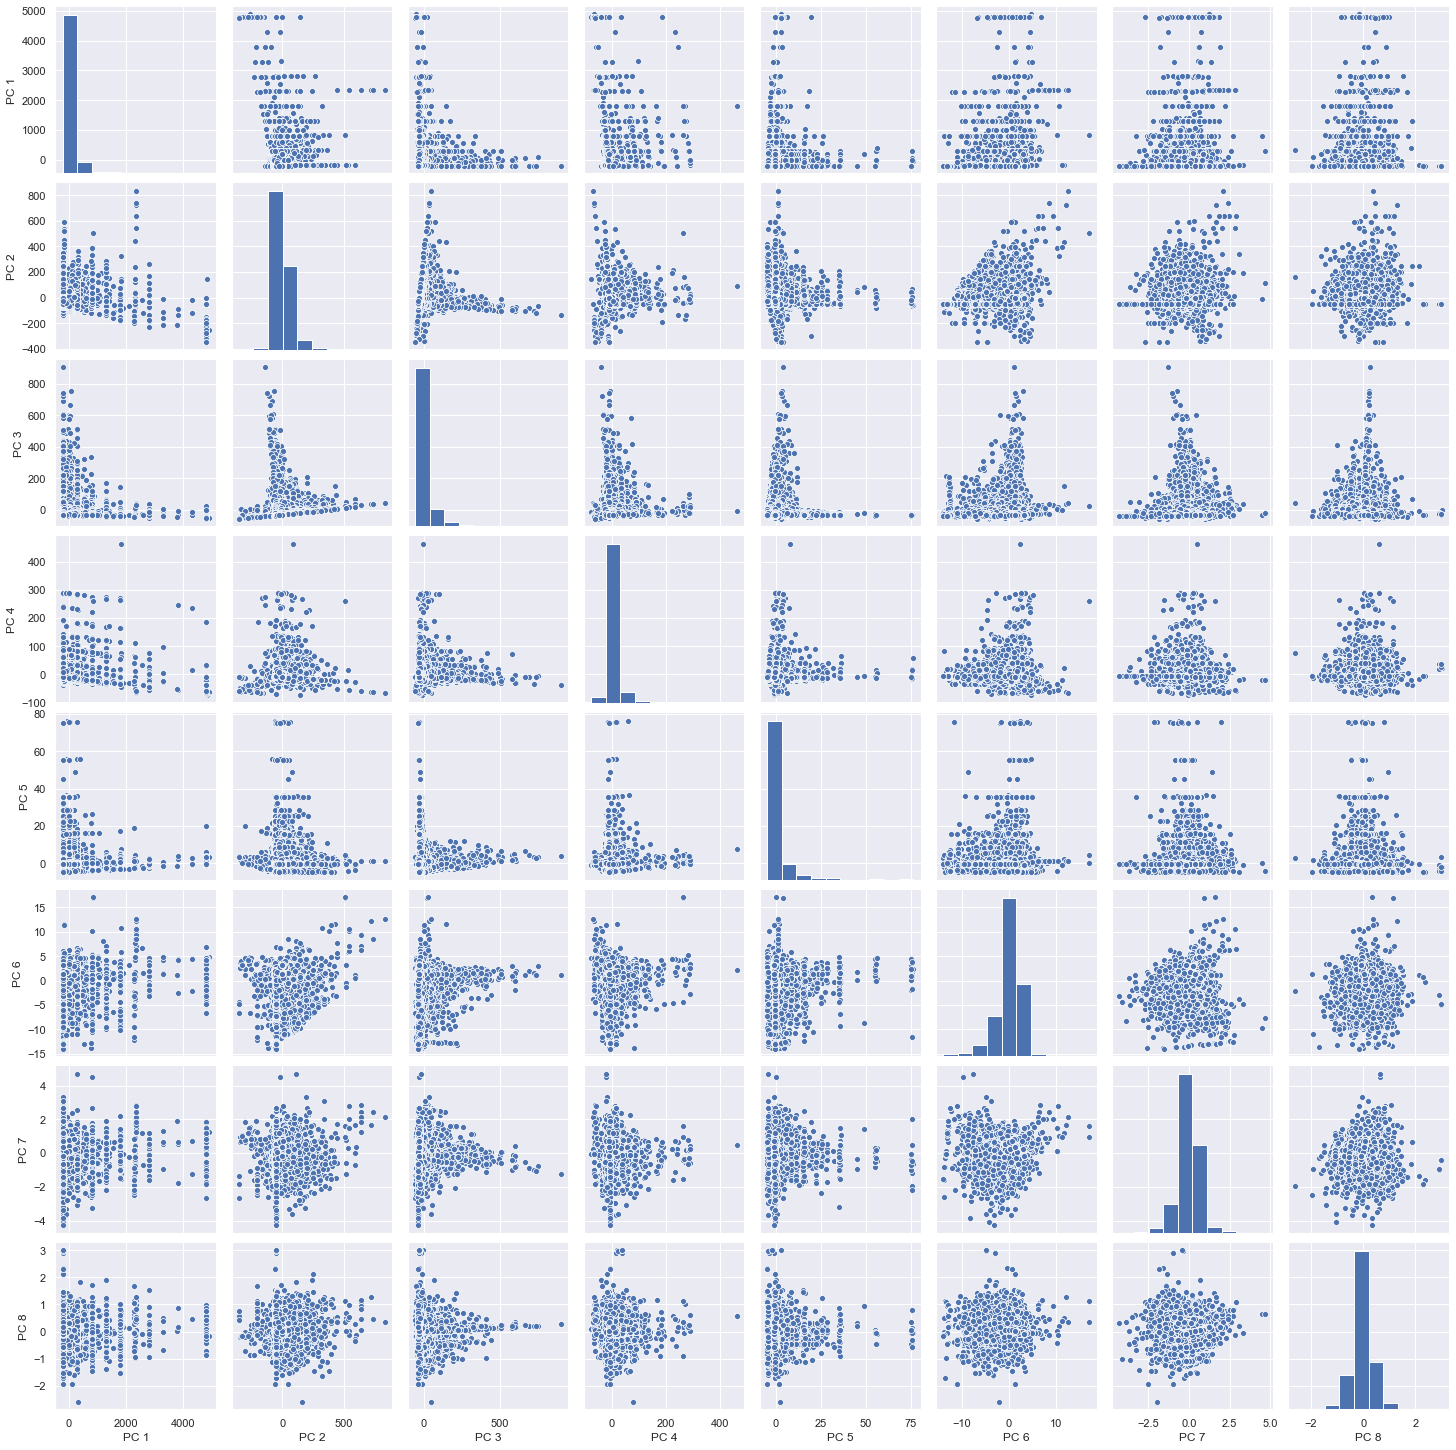

In [9]:
# Create the scaler
scaler = StandardScaler()
ansur_std = scaler.fit_transform(df_X)

# Create the PCA instance and fit and transform the data with pca
pca = PCA()
pc = pca.fit_transform(df_X)
pc_df = pd.DataFrame(pc, columns=['PC 1', 'PC 2', 'PC 3', 'PC 4', 'PC 5', 'PC 6', 'PC 7', 'PC 8'])

# Create a pairplot of the principal component dataframe
sns.pairplot(pc_df)
plt.show()

In [10]:
# Build the pipeline
pipe = Pipeline([('scaler', StandardScaler()),
        		 ('reducer', PCA(n_components=2))])
                 
                 
#2. Fit the pipeline to the poke_df dataset and extract the component vectors.

# Fit it to the dataset and extract the component vectors
pipe.fit(df_X)
vectors = pipe.steps[1][1].components_.round(2)

# Print feature effects
print('PC 1 effects = ' + str(dict(zip(df_X.columns, vectors[0]))))
print('PC 2 effects = ' + str(dict(zip(df_X.columns, vectors[1]))))

PC 1 effects = {'bathrooms': 0.49, 'bedrooms': 0.51, 'accommodates': 0.48, 'extra_people': 0.13, 'security_deposit': 0.26, 'cleaning_fee': 0.43, 'review_scores_rating': 0.03, 'number_of_reviews': -0.04}
PC 2 effects = {'bathrooms': -0.11, 'bedrooms': -0.11, 'accommodates': -0.14, 'extra_people': 0.57, 'security_deposit': 0.35, 'cleaning_fee': 0.02, 'review_scores_rating': 0.52, 'number_of_reviews': 0.5}


In [11]:
pipe.steps[1][1].components_.round(2)

array([[ 0.49,  0.51,  0.48,  0.13,  0.26,  0.43,  0.03, -0.04],
       [-0.11, -0.11, -0.14,  0.57,  0.35,  0.02,  0.52,  0.5 ]])

In [12]:
# Pipe a scaler to PCA selecting 80% of the variance
pipe = Pipeline([('scaler', StandardScaler()),
        		 ('reducer', PCA(n_components=0.8))])
                 
                 
#2. Fit the pipe to the data.
# Fit the pipe to the data
pipe.fit(df_X)

print('{} components selected'.format(len(pipe.steps[1][1].components_)))



#3. Increase the proportion of variance to keep to 90%.

# Let PCA select 90% of the variance
pipe = Pipeline([('scaler', StandardScaler()),
        		 ('reducer', PCA(n_components=0.9))])

# Fit the pipe to the data
pipe.fit(df_X)

print('{} components selected'.format(len(pipe.steps[1][1].components_)))

5 components selected
6 components selected


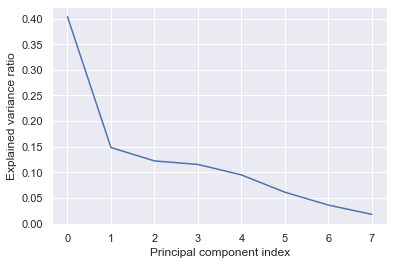

In [13]:
# Pipeline a scaler and PCA selecting 10 components
pipe = Pipeline([('scaler', StandardScaler()),
        		 ('reducer', PCA(n_components=8))])
                 
                 
#2. Fit the pipe to the data.

# Fit the pipe to the data
pipe.fit(df_X)


#3. Plot the explained variance ratio.

# Plot the explained variance ratio
plt.plot(pipe.steps[1][1].explained_variance_ratio_)

plt.xlabel('Principal component index')
plt.ylabel('Explained variance ratio')
plt.show()

In [14]:
# Build the pipeline
pipe = Pipeline([('scaler', StandardScaler()),
        		 ('reducer', PCA(n_components=1))])
                 
                 
#2. Fit the pipeline to the poke_df dataset and extract the component vectors.

# Fit it to the dataset and extract the component vectors
pipe.fit(df_X)
vectors = pipe.steps[1][1].components_.round(2)

# Print feature effects
print('PC 1 effects = ' + str(dict(zip(df_X.columns, vectors[0]))))

PC 1 effects = {'bathrooms': 0.49, 'bedrooms': 0.51, 'accommodates': 0.48, 'extra_people': 0.13, 'security_deposit': 0.26, 'cleaning_fee': 0.43, 'review_scores_rating': 0.03, 'number_of_reviews': -0.04}


In [15]:
# Scale the quantitative features
#scaler = MinMaxScaler()
scaler = StandardScaler()
numerical = [
    'bathrooms',
    'bedrooms',
    'accommodates',
    'extra_people',
    'security_deposit',
    'cleaning_fee',
    'review_scores_rating',
    'number_of_reviews',
]
features_scaled = features.copy()
features_scaled[numerical] = scaler.fit_transform(features_scaled[numerical])

In [16]:
features_scaled.head()

bathrooms  bedrooms  accommodates  review_scores_rating  number_of_reviews  \
0   0.639457  0.177499     -0.200070             -0.466824          -0.124094   
1  -0.671257 -0.744009     -0.857064             -0.781579          -0.358995   
2  -0.671257 -0.744009     -0.528567              0.162687           7.784230   
3  -0.671257 -0.744009     -0.857064              0.320065           3.524697   
4  -0.671257 -0.744009     -0.857064              0.477442           1.253990   

   extra_people  security_deposit  cleaning_fee  property_type_Bungalow  \
0      0.654460          0.631798      0.404054                       0   
1      0.845053          0.631798      0.082104                       0   
2      1.226239         -0.222620     -0.883745                       0   
3     -0.489098         -0.436225     -0.883745                       0   
4      0.463867         -0.436225     -0.239846                       0   

   property_type_Condominium  ...  property_type_Serviced apartment  \
0                          0  ...                                 0   
1                          0  ...                                 0   
2                          0  ...                                 0   
3                          0  ...                                 0   
4                          0  ...                                 0   

   property_type_Townhouse  room_type_Hotel room  room_type_Private room  \
0                        0                     0                       0   
1                        0                     0                       1   
2                        0                     0                       0   
3                        0                     0                       1   
4                        0                     0                       0   

   room_type_Shared room  host_is_superhost_t  region_East  region_North  \
0                      0                    1            1             0   
1                      0                    1            1             0   
2                      0                    1            1             0   
3                      0                    1            0             1   
4                      0                    1            0             0   

   region_South  region_West  
0             0            0  
1             0            0  
2             0            0  
3             0            0  
4             1            0  

[5 rows x 25 columns]

In [17]:
#features_scaled.to_csv('data/listings_scaled.csv')

### Modeling:

In [18]:
X_train, X_test, y_train, y_test = train_test_split(features_scaled, 
                                                    log_y, 
                                                    test_size = .30, 
                                                    random_state = 42)
                                                    #stratify=log_y)

# Show the results of the split
print("Training set has {} samples.".format(X_train.shape[0]))
print("Test set has {} samples.".format(X_test.shape[0]))

Training set has 8078 samples.
Test set has 3463 samples.


In [19]:
y_test.describe()

price
count  3463.000000
mean      5.020878
std       0.942040
min       2.772589
25%       4.369448
50%       4.867534
75%       5.581613
max       8.853665

In [20]:
y_train.describe()

price
count  8078.000000
mean      5.055603
std       0.939243
min       2.772589
25%       4.430817
50%       4.934474
75%       5.686975
max       8.922658

In [21]:
models = [SVR(kernel='linear'),
          DecisionTreeRegressor(max_depth= 7, min_samples_leaf= 10),
          LinearRegression(),
          KNeighborsRegressor(n_neighbors=7),
          RandomForestRegressor(n_estimators=500, random_state=42)]

results = {}

for model in models:
    
    # Instantiate and fit Regressor Model
    reg_model = model
    reg_model.fit(X_train, y_train.values.ravel())
    
    # Make predictions with model
    y_test_preds = reg_model.predict(X_test)
    
    # Grab model name and store results associated with model
    name = str(model).split("(")[0]
    results[name] = r2_score(y_test, y_test_preds)
    
results_df = pd.DataFrame(results.values(), index=results.keys(), columns=['R2 Score'])
print(results_df)

                       R2 Score
SVR                    0.481190
DecisionTreeRegressor  0.523958
LinearRegression       0.488922
KNeighborsRegressor    0.519051
RandomForestRegressor  0.607863


                       R2 Score
RandomForestRegressor  0.607863
DecisionTreeRegressor  0.523958
KNeighborsRegressor    0.519051
LinearRegression       0.488922
SVR                    0.481190


Text(0.5, 1.0, 'Comparison of Regression Models')

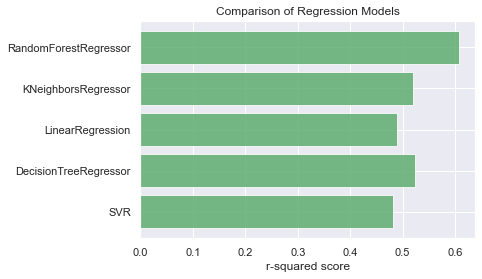

In [22]:
results_df = pd.DataFrame(results.values(), index=results.keys(), columns=['R2 Score'])
print(results_df.sort_values('R2 Score', ascending=False))

fig, ax = plt.subplots()

ind = range(len(results))
ax.barh(ind, list(results.values()), align='center', 
        color = '#55a868', alpha=0.8)
ax.set_yticks(ind)
ax.set_yticklabels(results.keys())
ax.set_xlabel('r-squared score')
ax.tick_params(left=False, top=False, right=False) 
ax.set_title('Comparison of Regression Models')
#fig.savefig('images/compare_models.png', bbox_inches = 'tight')

In [23]:
# # Import TPOTRegressor and roc_auc_score
# from tpot import TPOTRegressor
# from sklearn.metrics import r2_score

# # Instantiate TPOTRegressor
# tpot = TPOTRegressor(
#     generations=5,
#     population_size=20,
#     verbosity=2,
#     scoring='r2',
#     random_state=42,
#     disable_update_check=True,
#     config_dict='TPOT light'
# )
# tpot.fit(X_train, y_train)

# # AUC score for tpot model
# tpot_score = r2_score(y_test, tpot.predict(X_test))
# print(f'\nAUC score: {tpot_score:.4f}')

# # Print best pipeline steps
# print('\nBest pipeline steps:', end='\n')
# for idx, (name, transform) in enumerate(tpot.fitted_pipeline_.steps, start=1):
#     # Print idx and transform
#     print(f'{idx}. {transform}')

In [24]:
# Training Decision Tree Regressor Model
modelDTR = DecisionTreeRegressor()

modelDTR.fit(X_train, y_train)

DecisionTreeRegressor()

In [25]:
X_test

bathrooms  bedrooms  accommodates  review_scores_rating  \
9193    0.639457  2.020514      1.770912             -0.466824   
6112    0.639457  0.177499      0.456924             -0.466824   
967     0.639457  1.099006      1.113918              0.634820   
11279   0.639457  2.020514      1.113918              0.000761   
3061    0.639457  0.177499     -0.200070              0.477442   
...          ...       ...           ...                   ...   
266     1.294815  2.020514      1.113918             -0.466824   
1108   -0.671257 -0.744009     -0.857064              0.320065   
8847    0.639457  1.099006      0.128427              0.634820   
10451  -0.015900  0.177499     -0.200070              0.000761   
3229   -0.671257 -0.744009     -0.857064              0.634820   

       number_of_reviews  extra_people  security_deposit  cleaning_fee  \
9193           -0.155415     -0.489098         -0.009016      0.983563   
6112           -0.452955     -0.489098         -0.436225      0.545711   
967            -0.468616      1.836137          0.204589      1.047953   
11279          -0.499936     -0.489098         -0.436225     -0.883745   
3061            0.408347     10.946482          2.767842     -0.883745   
...                  ...           ...               ...           ...   
266            -0.171075      0.273274          2.767842      0.017714   
1108            0.095146     -0.489098          0.204589     -0.381503   
8847           -0.124094     -0.489098         -0.222620     -0.883745   
10451          -0.499936     -0.489098         -0.436225     -0.883745   
3229            0.517968      0.845053          0.631798     -0.433015   

       property_type_Bungalow  property_type_Condominium  ...  \
9193                        0                          0  ...   
6112                        0                          0  ...   
967                         0                          0  ...   
11279                       0                          0  ...   
3061                        0                          0  ...   
...                       ...                        ...  ...   
266                         0                          0  ...   
1108                        0                          0  ...   
8847                        0                          0  ...   
10451                       0                          0  ...   
3229                        0                          0  ...   

       property_type_Serviced apartment  property_type_Townhouse  \
9193                                  0                        0   
6112                                  0                        0   
967                                   0                        0   
11279                                 0                        0   
3061                                  0                        0   
...                                 ...                      ...   
266                                   0                        0   
1108                                  0                        0   
8847                                  0                        0   
10451                                 0                        0   
3229                                  0                        0   

       room_type_Hotel room  room_type_Private room  room_type_Shared room  \
9193                      0                       0                      0   
6112                      0                       0                      0   
967                       0                       0                      0   
11279                     0                       0                      0   
3061                      0                       0                      0   
...                     ...                     ...                    ...   
266                       0                       0                      0   
1108                      0                       0                      0   
8847                     

In [26]:
y_test

price
9193   4.828314
6112   7.013915
967    6.214608
11279  5.298317
3061   5.298317
...         ...
266    6.476972
1108   4.859812
8847   5.075174
10451  5.192957
3229   4.499810

[3463 rows x 1 columns]

In [27]:
modelDTR.score(X_test, y_test)

0.3065948069420935

In [28]:
# Accuracy score for Decision Tree
y_pred = modelDTR.predict(X_test)
cross_val_score(modelDTR, features_scaled, y, cv=10)
print('Decision Tree Regressor accuracy: {:.2f}'.format(r2_score(y_test, y_pred)))

Decision Tree Regressor accuracy: 0.31


#### Decision Tree Regressor:
##### Hyperparameter Tuning:

In [29]:
# Using GridSearchCV on DecisionTreeRegressor
#create a dictionary of all values we want to test
param_grid = {"max_depth": np.arange(1, 21),
              "max_features": np.arange(1, 9),
              "min_samples_leaf": [20, 40, 100],
              "min_samples_split": [10, 20, 40],
              "max_leaf_nodes": [5, 20, 100],
              #"criterion": ["mse", "mae"]
             }
#use gridsearch to test all values
dtr_cv = GridSearchCV(modelDTR, param_grid, cv=5)
#fit model to data
dtr_cv.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=DecisionTreeRegressor(),
             param_grid={'max_depth': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20]),
                         'max_features': array([1, 2, 3, 4, 5, 6, 7, 8]),
                         'max_leaf_nodes': [5, 20, 100],
                         'min_samples_leaf': [20, 40, 100],
                         'min_samples_split': [10, 20, 40]})

In [30]:
# print(dtr_cv.best_params_)
# print(cross_val_score(modelDTR, features_scaled, y, cv=10))

##### dtr_cv.best_params_:
{'max_depth': 10, 'max_features': 8, 'max_leaf_nodes': 100, 'min_samples_leaf': 20, 'min_samples_split': 40}

In [31]:
modelDTR = DecisionTreeRegressor(max_depth = 10, max_features = 8, max_leaf_nodes = 100,
                                 min_samples_leaf= 20, min_samples_split = 40)
modelDTR.fit(X_train, y_train)
y_test_preds = modelDTR.predict(X_test)
print(y_test_preds)
r2_score(y_test, y_test_preds)

[5.66186365 6.3080767  5.89517765 ... 5.47045605 5.95517568 4.59227973]


0.5364769052859146

In [32]:
lr = LinearRegression()
# Pass data to the LR model
lr.fit(X_train,y_train)
y_test_preds = lr.predict(X_test)
r2_score(y_test, y_test_preds)

0.48892216184419046

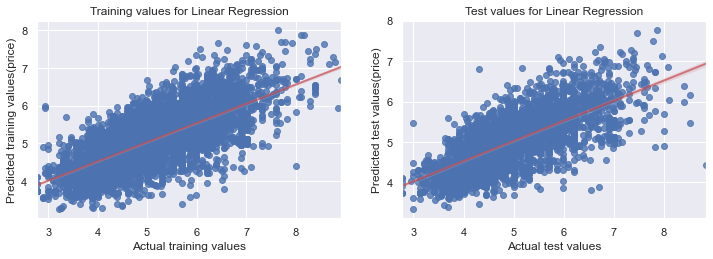

In [33]:
plt.figure(figsize=(12,8))
plt.subplot(2,2,1)
sns.regplot(y_train, lr.predict(X_train), line_kws={"color":"r","alpha":0.7,"lw":2})
plt.xlabel('Actual training values')
plt.ylabel('Predicted training values(price)')
plt.title('Training values for Linear Regression')
plt.subplot(2,2,2)
sns.regplot(y_test, lr.predict(X_test), line_kws={"color":"r","alpha":0.7,"lw":2})
plt.xlabel('Actual test values')
plt.ylabel('Predicted test values(price)')
plt.title('Test values for Linear Regression')
plt.show()

In [34]:
knn = KNeighborsRegressor()
# Create 3 folds
kfold = KFold(n_splits=3, shuffle=True, random_state=42)
# Define our hyperparameters
params = [{'n_neighbors': [2,3,4,5,6], 'weights': ['uniform','distance']}]

# Search for best hyperparameters
grid = GridSearchCV(estimator=knn, param_grid=params, cv=kfold, scoring='r2')
grid.fit(X_train, y_train)

GridSearchCV(cv=KFold(n_splits=3, random_state=42, shuffle=True),
             estimator=KNeighborsRegressor(),
             param_grid=[{'n_neighbors': [2, 3, 4, 5, 6],
                          'weights': ['uniform', 'distance']}],
             scoring='r2')

In [35]:
# Get the results
print(grid.best_score_)
print(grid.best_estimator_)
print(grid.best_params_)

0.535416519847712
KNeighborsRegressor(n_neighbors=6)
{'n_neighbors': 6, 'weights': 'uniform'}


In [36]:
knn = KNeighborsRegressor(n_neighbors= 6, weights= 'uniform')
knn.fit(X_train, y_train)
predictions = knn.predict(X_test)
knn_mse = mean_squared_error(predictions, y_test)
knn_mse

0.42937557673014665

#### Random Forest Regressor:
##### Hyperparameter Tuning:

In [37]:
modelRFR = RandomForestRegressor(random_state=42)

In [38]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 1200, num = 12)]
# Number of features to consider at every split
max_features = ['auto']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(5, 30, num = 6)]
# max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10, 15, 100]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 5, 10]
# Method of selecting samples for training each tree
# bootstrap = [True, False]

# Create the random grid
param_grid = { 
    #'n_estimators': n_estimators,
    'max_features': max_features,
    'max_depth': max_depth,
    'min_samples_split': min_samples_split,
    'min_samples_leaf': min_samples_leaf,
    'bootstrap': [True]
}

In [39]:
# %%time
# CV_RFR = GridSearchCV(estimator=modelRFR, param_grid=param_grid, cv= 5)
# CV_RFR.fit(X_train, np.ravel(y_train))

In [40]:
#CV_RFR.best_params_

##### CV_RFR.best_params_:
{'bootstrap': True,
 'max_depth': 15,
 'max_features': 'auto',
 'min_samples_leaf': 2,
 'min_samples_split': 10}

In [41]:
modelRFR=RandomForestRegressor(max_features='auto', n_estimators= 1000, max_depth=15, min_samples_split=10, min_samples_leaf=2, bootstrap=True, random_state=42)

#### XGB Regressor:
##### Hyperparameter Tuning:

In [42]:
xgb1 = XGBRegressor()
parameters = {'nthread':[4], #when use hyperthread, xgboost may become slower
              'objective':['reg:linear'],
              'learning_rate': [.03, 0.05, .07], #so called `eta` value
              'max_depth': [5, 6, 7],
              'min_child_weight': [4],
              'silent': [1],
              'subsample': [0.7],
              'colsample_bytree': [0.7],
              'n_estimators': [500]}

xgb_grid = GridSearchCV(xgb1,
                        parameters,
                        cv = 5,
                        n_jobs = 5,
                        verbose=True)

In [43]:
xgb_grid.fit(X_train, y_train)

Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  45 out of  45 | elapsed:  1.9min finished


GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, gamma=None,
                                    gpu_id=None, importance_type='gain',
                                    interaction_constraints=None,
                                    learning_rate=None, max_delta_step=None,
                                    max_depth=None, min_child_weight=None,
                                    missing=nan, monotone_constraints=None,
                                    n_estimators=100, n_jobs=...
                                    reg_alpha=None, reg_lambda=None,
                                    scale_pos_weight=None, subsample=None,
                                    tree_method=None, validate_parameters=False,
                                    verbosity=None),
             n

In [44]:
xgb_grid.best_params_

{'colsample_bytree': 0.7,
 'learning_rate': 0.03,
 'max_depth': 6,
 'min_child_weight': 4,
 'n_estimators': 500,
 'nthread': 4,
 'objective': 'reg:linear',
 'silent': 1,
 'subsample': 0.7}

##### xgb.best_params_:
{'colsample_bytree': 0.7,
 'learning_rate': 0.03,
 'max_depth': 6,
 'min_child_weight': 4,
 'n_estimators': 500,
 'nthread': 4,
 'objective': 'reg:linear',
 'silent': 1,
 'subsample': 0.7}

In [45]:
print("Best Params XGB MSE:", round(mean_squared_error(y_test, xgb_grid.predict(X_test)),4))
print("Best Params XGB r2:", round(r2_score(y_test, xgb_grid.predict(X_test)),4))

Best Params XGB MSE: 0.3251
Best Params XGB r2: 0.6335


In [46]:
xgb_reg_start = time.time()

xgb_reg = xgb.XGBRegressor(
    colsample_bytree= 0.7,
    learning_rate= 0.03,
    max_depth= 6,
    min_child_weight= 4,
    n_estimators= 500,
    nthread= 4,
    objective= 'reg:linear',
    silent= 1,
    subsample= 0.7
)
xgb_reg.fit(X_train, y_train)
training_preds_xgb_reg = xgb_reg.predict(X_train)
test_preds_xgb_reg = xgb_reg.predict(X_test)

xgb_reg_end = time.time()

print(f"Time taken to run: {round((xgb_reg_end - xgb_reg_start)/60,1)} minutes")
print("\nTraining MSE:", round(mean_squared_error(y_train, training_preds_xgb_reg),4))
print("Test MSE:", round(mean_squared_error(y_test, test_preds_xgb_reg),4))
print("\nTraining r2:", round(r2_score(y_train, training_preds_xgb_reg),4))
print("Test r2:", round(r2_score(y_test, test_preds_xgb_reg),4))

Time taken to run: 0.1 minutes

Training MSE: 0.2059
Test MSE: 0.3251

Training r2: 0.7666
Test r2: 0.6335


In [47]:
# models with hyperparameter tuning

models = [SVR(kernel='linear'),
          modelDTR,
          LinearRegression(),
          knn,
          modelRFR,
          xgb_reg]

results = {}

for model in models:
    
    # Instantiate and fit Regressor Model
    reg_model = model
    reg_model.fit(X_train, y_train.values.ravel())
    
    # Make predictions with model
    y_test_preds = reg_model.predict(X_test)
    
    # Grab model name and store results associated with model
    name = str(model).split("(")[0]
    results[name] = r2_score(y_test, y_test_preds)
    
results_df = pd.DataFrame(results.values(), index=results.keys(), columns=['R2 Score'])
print(results_df)

                       R2 Score
SVR                    0.481190
DecisionTreeRegressor  0.521344
LinearRegression       0.488922
KNeighborsRegressor    0.516024
RandomForestRegressor  0.620560
XGBRegressor           0.633508


                       R2 Score
XGBRegressor           0.633508
RandomForestRegressor  0.620560
DecisionTreeRegressor  0.521344
KNeighborsRegressor    0.516024
LinearRegression       0.488922
SVR                    0.481190


Text(0.5, 1.0, 'Comparison of Regression Models')

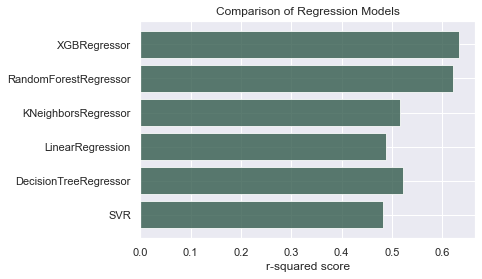

In [48]:
results_df = pd.DataFrame(results.values(), index=results.keys(), columns=['R2 Score'])
print(results_df.sort_values('R2 Score', ascending=False))

fig, ax = plt.subplots()

ind = range(len(results))
ax.barh(ind, list(results.values()), align='center', 
        color = '#325A4C', alpha=0.8)
ax.set_yticks(ind)
ax.set_yticklabels(results.keys())
ax.set_xlabel('r-squared score')
ax.tick_params(left=False, top=False, right=False) 
ax.set_title('Comparison of Regression Models')
#fig.savefig('images/compare_models.png', bbox_inches = 'tight')

In [49]:
# Plotly to visualize the feature importances
import plotly.graph_objs as go
from plotly.offline import iplot, plot, init_notebook_mode
import plotly.express as px

#### Random Forest Feature Importance

In [50]:
feature_importance = modelRFR.feature_importances_
feature_importance

array([0.10698879, 0.21466784, 0.19846812, 0.02448014, 0.11233149,
       0.03024647, 0.03858603, 0.10861975, 0.00127061, 0.00588917,
       0.00055795, 0.00149497, 0.00941303, 0.00249926, 0.00729182,
       0.00283465, 0.00133622, 0.00073189, 0.06250197, 0.02218781,
       0.01123259, 0.00855488, 0.01279934, 0.01065209, 0.00436314])

In [51]:
features_scaled.columns

Index(['bathrooms', 'bedrooms', 'accommodates', 'review_scores_rating',
       'number_of_reviews', 'extra_people', 'security_deposit', 'cleaning_fee',
       'property_type_Bungalow', 'property_type_Condominium',
       'property_type_Guest suite', 'property_type_Guesthouse',
       'property_type_House', 'property_type_Loft', 'property_type_Other',
       'property_type_Serviced apartment', 'property_type_Townhouse',
       'room_type_Hotel room', 'room_type_Private room',
       'room_type_Shared room', 'host_is_superhost_t', 'region_East',
       'region_North', 'region_South', 'region_West'],
      dtype='object')

In [52]:
importances = pd.DataFrame({'feature': features_scaled.columns, 'importance': feature_importance}).sort_values('importance', ascending=False).reset_index(drop=True)

trace = go.Bar(x=importances.head(40).feature, y=importances.head(10).importance)

layout = go.Layout(title='Random Forest Feature Importances',
                  yaxis=dict(title='Relative Importance'))

fig = go.Figure([trace], layout)
fig.update_xaxes(tickangle=90)
iplot(fig, filename='feature_importance.html')

#### XGB Feature Importance

In [53]:
feature_importance = xgb_reg.feature_importances_
feature_importance

array([0.10075936, 0.14070076, 0.12589632, 0.01344803, 0.0289712 ,
       0.01921181, 0.01747506, 0.03447807, 0.01076452, 0.01889634,
       0.01312582, 0.01108733, 0.01796905, 0.02207724, 0.02015894,
       0.02297726, 0.01451814, 0.01505063, 0.17430711, 0.08955817,
       0.02038344, 0.01146263, 0.03082396, 0.01288432, 0.01301457],
      dtype=float32)

In [54]:
importances = pd.DataFrame({'feature': features_scaled.columns, 'importance': feature_importance}).sort_values('importance', ascending=False).reset_index(drop=True)

trace = go.Bar(x=importances.head(40).feature, y=importances.head(10).importance)

layout = go.Layout(title='XGB Feature Importances',
                  yaxis=dict(title='Relative Importance'))

fig = go.Figure([trace], layout)
fig.update_xaxes(tickangle=90)
iplot(fig, filename='feature_importance.html')

In [55]:
import statsmodels.api as sm

X_train_ = sm.add_constant(X_train)

ols_model = sm.OLS(y_train, X_train_.astype(float))
res = ols_model.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.510
Model:                            OLS   Adj. R-squared:                  0.508
Method:                 Least Squares   F-statistic:                     334.9
Date:                Thu, 06 Aug 2020   Prob (F-statistic):               0.00
Time:                        17:36:44   Log-Likelihood:                -8075.9
No. Observations:                8078   AIC:                         1.620e+04
Df Residuals:                    8052   BIC:                         1.639e+04
Df Model:                          25                                         
Covariance Type:            nonrobust                                         
                                       coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
const   

The OLS results summary provides a brief description on how each feature measures with its p-value and other test scores, which is very useful in selecting our features for the model. We can select our features using p-value set at 0.05 as a standard measure so that we can avoid collinearity issues.

In [56]:
# Training the data again by removing some features which may not be useful in detecting the price in our model.

X_train_new = X_train_.drop(columns=["review_scores_rating", "property_type_Guesthouse", "property_type_Serviced apartment",
                                    "property_type_Bungalow", "property_type_House"], axis=1)

ols_model_new = sm.OLS(y_train, X_train_new.astype(float))
res_new = ols_model_new.fit()

print(res_new.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.510
Model:                            OLS   Adj. R-squared:                  0.508
Method:                 Least Squares   F-statistic:                     418.8
Date:                Thu, 06 Aug 2020   Prob (F-statistic):               0.00
Time:                        17:36:44   Log-Likelihood:                -8076.8
No. Observations:                8078   AIC:                         1.620e+04
Df Residuals:                    8057   BIC:                         1.634e+04
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                 

In [57]:
xg_reg = XGBRegressor(
    colsample_bytree= 0.7,
    learning_rate= 0.03,
    max_depth= 5,
    min_child_weight= 4,
    n_estimators= 500,
    nthread= 4,
    objective= 'reg:linear',
    silent= 1,
    subsample= 0.7,
    random_state= 42
)

In [58]:
xg_reg.fit(X_train,y_train)
y_pred_test = xg_reg.predict(X_test)
y_pred_train = xg_reg.predict(X_train)

In [59]:
test_rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))
train_rmse = np.sqrt(mean_squared_error(y_train, y_pred_train))
print("Test RMSE: %f" % (test_rmse))
print("Train RMSE: %f" % (train_rmse))
#print("Test RMSLE:", round(mean_squared_log_error(y_test, y_pred_test),4))
#print("Train RMSLE:", round(mean_squared_log_error(y_train, y_pred_train),4))
print("Test R2:", round(r2_score(y_test, y_pred_test),4))
print("Train R2:", round(r2_score(y_train, y_pred_train),4))

Test RMSE: 0.574808
Train RMSE: 0.484778
Test R2: 0.6276
Train R2: 0.7336


In [60]:
y_pred_test = pd.DataFrame(y_pred_test)
y_pred_test.index = y_test.index
y_pred_test

0
9193   5.617224
6112   6.917284
967    5.936452
11279  6.592085
3061   5.530782
...         ...
266    5.620767
1108   4.612611
8847   5.282416
10451  5.412495
3229   4.559143

[3463 rows x 1 columns]

In [61]:
y_test.rename(columns={"price":'Actual Price'}, inplace=True)
y_test

Actual Price
9193       4.828314
6112       7.013915
967        6.214608
11279      5.298317
3061       5.298317
...             ...
266        6.476972
1108       4.859812
8847       5.075174
10451      5.192957
3229       4.499810

[3463 rows x 1 columns]

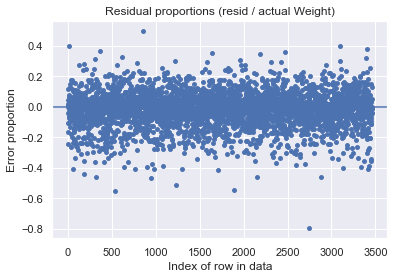

In [62]:
# Let's see how close or far off our predictions are comparing to the actual values
y_actual = y_test.values
resid = y_actual - y_pred_test
resid_prop = resid / y_actual
plt.scatter(np.arange(len(resid_prop)), resid_prop, s=15)
plt.axhline(0)
plt.title('Residual proportions (resid / actual Weight)')
plt.xlabel('Index of row in data')
plt.ylabel('Error proportion');

#### The residual proportions indicate that our predictions are mostly within 20-25% of the correct value.

In [63]:
test_preds = pd.concat([y_test, y_pred_test], axis=1)
test_preds.columns = ['Actual Price', 'Predicted Price']
#test_preds['Actual Price'] = np.exp(test_preds['Actual Price'])
#test_preds['Predicted Price'] = np.exp(test_preds['Predicted Price'])
test_preds

Actual Price  Predicted Price
9193       4.828314         5.617224
6112       7.013915         6.917284
967        6.214608         5.936452
11279      5.298317         6.592085
3061       5.298317         5.530782
...             ...              ...
266        6.476972         5.620767
1108       4.859812         4.612611
8847       5.075174         5.282416
10451      5.192957         5.412495
3229       4.499810         4.559143

[3463 rows x 2 columns]

In [64]:
test_preds['Percent Correct'] = round(test_preds['Predicted Price'] / test_preds['Actual Price'], 2)
test_preds['Residual'] = round(test_preds['Actual Price'] - test_preds['Predicted Price'], 2)
test_preds['Residual Proportions'] = round(test_preds['Residual'] / test_preds['Actual Price'], 2)

In [65]:
test_preds

Actual Price  Predicted Price  Percent Correct  Residual  \
9193       4.828314         5.617224             1.16     -0.79   
6112       7.013915         6.917284             0.99      0.10   
967        6.214608         5.936452             0.96      0.28   
11279      5.298317         6.592085             1.24     -1.29   
3061       5.298317         5.530782             1.04     -0.23   
...             ...              ...              ...       ...   
266        6.476972         5.620767             0.87      0.86   
1108       4.859812         4.612611             0.95      0.25   
8847       5.075174         5.282416             1.04     -0.21   
10451      5.192957         5.412495             1.04     -0.22   
3229       4.499810         4.559143             1.01     -0.06   

       Residual Proportions  
9193                  -0.16  
6112                   0.01  
967                    0.05  
11279                 -0.24  
3061                  -0.04  
...                     ...  
266                    0.13  
1108                   0.05  
8847                  -0.04  
10451                 -0.04  
3229                  -0.01  

[3463 rows x 5 columns]

In [66]:
print(test_preds['Residual Proportions'].min())
print(test_preds['Residual Proportions'].max())

-0.8
0.5


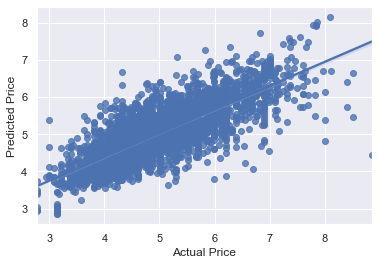

In [67]:
sns.regplot(x=test_preds['Actual Price'], y=test_preds['Predicted Price'], data=test_preds, ci=95)

In [68]:
y_pred_train = pd.DataFrame(y_pred_train)
y_pred_train.index = y_train.index
y_train.rename(columns={"price":'Actual Price'}, inplace=True)

In [69]:
train_preds = pd.concat([y_train, y_pred_train], axis=1)
train_preds.columns = ['Actual Price', 'Predicted Price']
#train_preds['Actual Price'] = np.exp(train_preds['Actual Price'])
#train_preds['Predicted Price'] = np.exp(train_preds['Predicted Price'])
train_preds['Percent Correct'] = round(train_preds['Predicted Price'] / train_preds['Actual Price'], 2)
train_preds['Residual'] = round(train_preds['Actual Price'] - train_preds['Predicted Price'], 2)
train_preds['Residual Proportions'] = round(train_preds['Residual'] / train_preds['Actual Price'], 2)
train_preds

Actual Price  Predicted Price  Percent Correct  Residual  \
9067       3.401197         4.637920             1.36     -1.24   
6475       4.700480         4.800107             1.02     -0.10   
5147       4.605170         4.503913             0.98      0.10   
3319       5.010635         4.944586             0.99      0.07   
8885       3.401197         3.724397             1.10     -0.32   
...             ...              ...              ...       ...   
11284      3.555348         3.700277             1.04     -0.14   
5191       3.401197         4.744052             1.39     -1.34   
5390       5.703782         5.749102             1.01     -0.05   
860        5.703782         4.956583             0.87      0.75   
7270       3.218876         4.067188             1.26     -0.85   

       Residual Proportions  
9067                  -0.36  
6475                  -0.02  
5147                   0.02  
3319                   0.01  
8885                  -0.09  
...                     ...  
11284                 -0.04  
5191                  -0.39  
5390                  -0.01  
860                    0.13  
7270                  -0.26  

[8078 rows x 5 columns]

In [70]:
print(train_preds['Residual Proportions'].min())
print(train_preds['Residual Proportions'].max())

-0.79
0.38


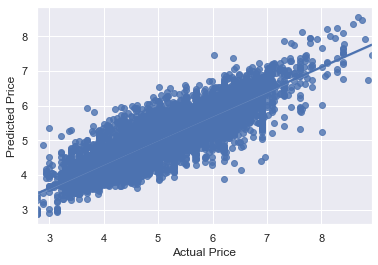

In [71]:
sns.regplot(x=train_preds['Actual Price'], y=train_preds['Predicted Price'], data=train_preds, ci=95)

In [72]:
preds_df = pd.concat([train_preds, test_preds])
preds_df

Actual Price  Predicted Price  Percent Correct  Residual  \
9067       3.401197         4.637920             1.36     -1.24   
6475       4.700480         4.800107             1.02     -0.10   
5147       4.605170         4.503913             0.98      0.10   
3319       5.010635         4.944586             0.99      0.07   
8885       3.401197         3.724397             1.10     -0.32   
...             ...              ...              ...       ...   
266        6.476972         5.620767             0.87      0.86   
1108       4.859812         4.612611             0.95      0.25   
8847       5.075174         5.282416             1.04     -0.21   
10451      5.192957         5.412495             1.04     -0.22   
3229       4.499810         4.559143             1.01     -0.06   

       Residual Proportions  
9067                  -0.36  
6475                  -0.02  
5147                   0.02  
3319                   0.01  
8885                  -0.09  
...                     ...  
266                    0.13  
1108                   0.05  
8847                  -0.04  
10451                 -0.04  
3229                  -0.01  

[11541 rows x 5 columns]

In [73]:
# Setting a threshold of .25
threshold = [0.75, 1.25]

In [74]:
threshold_25 = preds_df[(preds_df['Percent Correct'] >= threshold[0]) & (preds_df['Percent Correct'] <= threshold[1])]
threshold_25

Actual Price  Predicted Price  Percent Correct  Residual  \
6475       4.700480         4.800107             1.02     -0.10   
5147       4.605170         4.503913             0.98      0.10   
3319       5.010635         4.944586             0.99      0.07   
8885       3.401197         3.724397             1.10     -0.32   
1739       4.859812         4.269684             0.88      0.59   
...             ...              ...              ...       ...   
266        6.476972         5.620767             0.87      0.86   
1108       4.859812         4.612611             0.95      0.25   
8847       5.075174         5.282416             1.04     -0.21   
10451      5.192957         5.412495             1.04     -0.22   
3229       4.499810         4.559143             1.01     -0.06   

       Residual Proportions  
6475                  -0.02  
5147                   0.02  
3319                   0.01  
8885                  -0.09  
1739                   0.12  
...                     ...  
266                    0.13  
1108                   0.05  
8847                  -0.04  
10451                 -0.04  
3229                  -0.01  

[11222 rows x 5 columns]

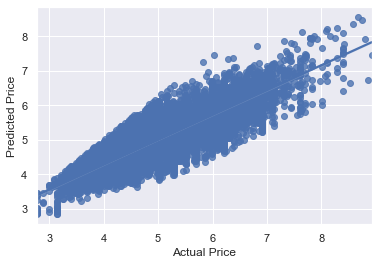

In [75]:
sns.regplot(x=threshold_25['Actual Price'], y=threshold_25['Predicted Price'], data=threshold_25, ci=95)

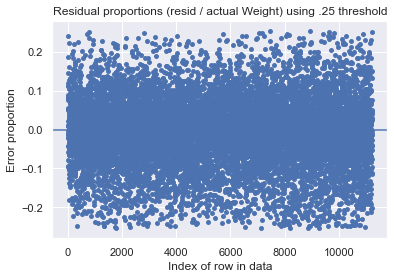

In [76]:
# Let's see how close or far off our predictions are comparing to the actual values
y_actual = threshold_25['Actual Price'].values
resid = y_actual - threshold_25['Predicted Price']
resid_prop = resid / y_actual
plt.scatter(np.arange(len(resid_prop)), resid_prop, s=15)
plt.axhline(0)
plt.title('Residual proportions (resid / actual Weight) using .25 threshold')
plt.xlabel('Index of row in data')
plt.ylabel('Error proportion');

In [77]:
# Calculate % of how many rental prices our model predicted in the .25 threshold range
threshold_25_percent_total = len(threshold_25)/len(preds_df)
print('Using .25 threshold, we get {:,d} rental prices out of {:,d} which means {:.1%} predicted are in range'.format(len(threshold_25),
                                                                         len(preds_df), len(threshold_25)/len(preds_df)))

Using .25 threshold, we get 11,222 rental prices out of 11,541 which means 97.2% predicted are in range


In [78]:
# Setting a threshold of .15
threshold = [0.85, 1.15]

threshold_15 = preds_df[(preds_df['Percent Correct'] >= threshold[0]) & (preds_df['Percent Correct'] <= threshold[1])]
threshold_15

Actual Price  Predicted Price  Percent Correct  Residual  \
6475       4.700480         4.800107             1.02     -0.10   
5147       4.605170         4.503913             0.98      0.10   
3319       5.010635         4.944586             0.99      0.07   
8885       3.401197         3.724397             1.10     -0.32   
1739       4.859812         4.269684             0.88      0.59   
...             ...              ...              ...       ...   
266        6.476972         5.620767             0.87      0.86   
1108       4.859812         4.612611             0.95      0.25   
8847       5.075174         5.282416             1.04     -0.21   
10451      5.192957         5.412495             1.04     -0.22   
3229       4.499810         4.559143             1.01     -0.06   

       Residual Proportions  
6475                  -0.02  
5147                   0.02  
3319                   0.01  
8885                  -0.09  
1739                   0.12  
...                     ...  
266                    0.13  
1108                   0.05  
8847                  -0.04  
10451                 -0.04  
3229                  -0.01  

[10121 rows x 5 columns]

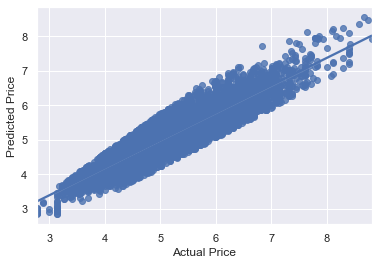

In [79]:
sns.regplot(x=threshold_15['Actual Price'], y=threshold_15['Predicted Price'], data=threshold_15, ci=95)

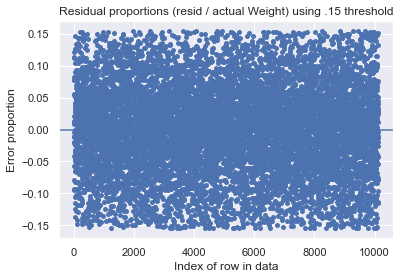

In [80]:
# Let's see how close or far off our predictions are comparing to the actual values
y_actual = threshold_15['Actual Price'].values
resid = y_actual - threshold_15['Predicted Price']
resid_prop = resid / y_actual
plt.scatter(np.arange(len(resid_prop)), resid_prop, s=15)
plt.axhline(0)
plt.title('Residual proportions (resid / actual Weight) using .15 threshold')
plt.xlabel('Index of row in data')
plt.ylabel('Error proportion');

In [81]:
# Calculate % of how many rental prices our model predicted in the .15 threshold range
threshold_15_percent_total = len(threshold_15)/len(preds_df)
print('Using .15 threshold, we get {:,d} rental prices out of {:,d} which means {:.1%} predicted are in range'.format(len(threshold_15),
                                                                         len(preds_df), len(threshold_15)/len(preds_df)))

Using .15 threshold, we get 10,121 rental prices out of 11,541 which means 87.7% predicted are in range


In [82]:
# Setting a threshold of .1
threshold = [0.90, 1.10]

threshold_10 = preds_df[(preds_df['Percent Correct'] >= threshold[0]) & (preds_df['Percent Correct'] <= threshold[1])]
threshold_10

Actual Price  Predicted Price  Percent Correct  Residual  \
6475       4.700480         4.800107             1.02     -0.10   
5147       4.605170         4.503913             0.98      0.10   
3319       5.010635         4.944586             0.99      0.07   
8885       3.401197         3.724397             1.10     -0.32   
230        4.595120         4.642210             1.01     -0.05   
...             ...              ...              ...       ...   
4264       4.912655         4.929311             1.00     -0.02   
1108       4.859812         4.612611             0.95      0.25   
8847       5.075174         5.282416             1.04     -0.21   
10451      5.192957         5.412495             1.04     -0.22   
3229       4.499810         4.559143             1.01     -0.06   

       Residual Proportions  
6475                  -0.02  
5147                   0.02  
3319                   0.01  
8885                  -0.09  
230                   -0.01  
...                     ...  
4264                  -0.00  
1108                   0.05  
8847                  -0.04  
10451                 -0.04  
3229                  -0.01  

[8515 rows x 5 columns]

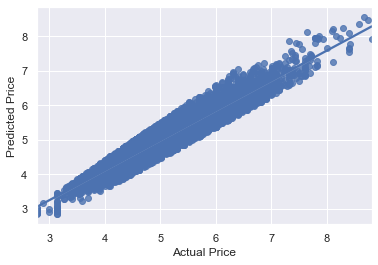

In [83]:
sns.regplot(x=threshold_10['Actual Price'], y=threshold_10['Predicted Price'], data=threshold_10, ci=95)

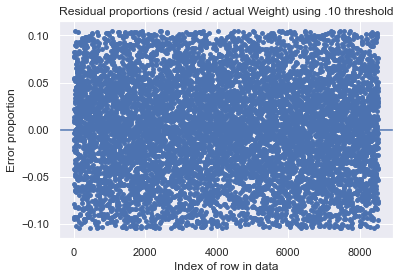

In [84]:
# Let's see how close or far off our predictions are comparing to the actual values
y_actual = threshold_10['Actual Price'].values
resid = y_actual - threshold_10['Predicted Price']
resid_prop = resid / y_actual
plt.scatter(np.arange(len(resid_prop)), resid_prop, s=15)
plt.axhline(0)
plt.title('Residual proportions (resid / actual Weight) using .10 threshold')
plt.xlabel('Index of row in data')
plt.ylabel('Error proportion');

In [85]:
# Calculate % of how many rental prices our model predicted in the .10 threshold range
threshold_10_percent_total = len(threshold_10)/len(preds_df)
print('Using .10 threshold, we get {:,d} rental prices out of {:,d} which means {:.1%} predicted are in range'.format(len(threshold_10),
                                                                         len(preds_df), len(threshold_10)/len(preds_df)))

Using .10 threshold, we get 8,515 rental prices out of 11,541 which means 73.8% predicted are in range


In [86]:
# Setting a threshold of .05
threshold = [0.95, 1.05]

threshold_5 = preds_df[(preds_df['Percent Correct'] >= threshold[0]) & (preds_df['Percent Correct'] <= threshold[1])]
threshold_5

Actual Price  Predicted Price  Percent Correct  Residual  \
6475       4.700480         4.800107             1.02     -0.10   
5147       4.605170         4.503913             0.98      0.10   
3319       5.010635         4.944586             0.99      0.07   
230        4.595120         4.642210             1.01     -0.05   
10449      5.834811         5.945178             1.02     -0.11   
...             ...              ...              ...       ...   
4264       4.912655         4.929311             1.00     -0.02   
1108       4.859812         4.612611             0.95      0.25   
8847       5.075174         5.282416             1.04     -0.21   
10451      5.192957         5.412495             1.04     -0.22   
3229       4.499810         4.559143             1.01     -0.06   

       Residual Proportions  
6475                  -0.02  
5147                   0.02  
3319                   0.01  
230                   -0.01  
10449                 -0.02  
...                     ...  
4264                  -0.00  
1108                   0.05  
8847                  -0.04  
10451                 -0.04  
3229                  -0.01  

[5580 rows x 5 columns]

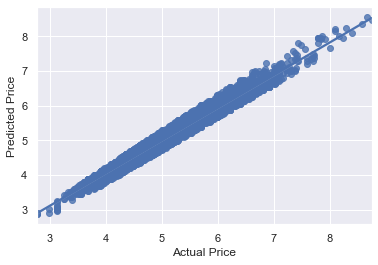

In [87]:
sns.regplot(x=threshold_5['Actual Price'], y=threshold_5['Predicted Price'], data=threshold_5, ci=95)

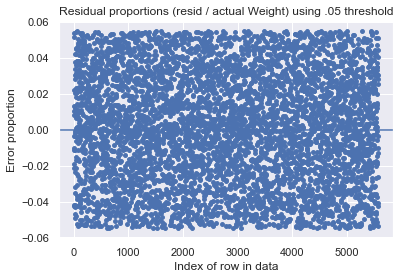

In [88]:
# Let's see how close or far off our predictions are comparing to the actual values
y_actual = threshold_5['Actual Price'].values
resid = y_actual - threshold_5['Predicted Price']
resid_prop = resid / y_actual
plt.scatter(np.arange(len(resid_prop)), resid_prop, s=15)
plt.axhline(0)
plt.title('Residual proportions (resid / actual Weight) using .05 threshold')
plt.xlabel('Index of row in data')
plt.ylabel('Error proportion');

In [89]:
# Calculate % of how many rental prices our model predicted in the .05 threshold range
threshold_5_percent_total = len(threshold_5)/len(preds_df)
print('Using .05 threshold, we get {:,d} rental prices out of {:,d} which means {:.1%} predicted are in range'.format(len(threshold_5),
                                                                         len(preds_df), len(threshold_5)/len(preds_df)))

Using .05 threshold, we get 5,580 rental prices out of 11,541 which means 48.3% predicted are in range


In [90]:
threshold_df = pd.DataFrame({'threshold':[.25, .15, .10, .5], 
                            '# Predictions in range':[threshold_25.shape[0], threshold_15.shape[0],
                                                          threshold_10.shape[0], threshold_5.shape[0]],
                            '% Predictions in range':[threshold_25_percent_total, threshold_15_percent_total,
                                                      threshold_10_percent_total, threshold_5_percent_total]})
threshold_df.head().style.format({"threshold":"{:.2f}", "# Predictions in range": "{:,.0f}", "% Predictions in range": "{:.0%}"})

In [91]:
# sample_df = preds_df.sample(frac=.9, random_state=42)
# sample_df[sample_df['Percent Correct']<0]

In [92]:
# threshold = [0.75, 1.25]

# sample_df[(sample_df['Percent Correct'] > threshold[0]) & (sample_df['Percent Correct'] < threshold[1])]

In [93]:
# sns.regplot(x=sample_df['Actual Price'], y=sample_df['Predicted Price'], data=sample_df, ci=95)

In [94]:
# # Let's see how close or far off our predictions are comparing to the actual values
# y_actual = sample_df['Actual Price'].values
# resid = y_actual - sample_df['Predicted Price']
# resid_prop = resid / y_actual
# plt.scatter(np.arange(len(resid_prop)), resid_prop, s=15)
# plt.axhline(0)
# plt.title('Residual proportions (resid / actual Weight)')
# plt.xlabel('Index of row in data')
# plt.ylabel('Error proportion');

In [95]:
# def simple_resample(n): 
#     return(np.random.randint(low = 0, high = n, size = n))

In [96]:
# def bootstrap(boot_pop, statistic, resample = simple_resample, replicates = 10000):
#     n = len(boot_pop)
#     resample_estimates = np.array([statistic(boot_pop[resample(n)]) for _ in range(replicates)])
#     return resample_estimates

In [97]:
# def bedrooms_coeff(data_array):
#     X = data_array[:, 1:]
#     y = data_array[:, 0]
    
#     linear_model = LinearRegression()
#     model = linear_model.fit(X, y)
#     theta_bedrooms = model.coef_[1]

#     return theta_bedrooms

# data_array = df_cleaned.loc[:, ["price", "bedrooms", "accommodates"]].values

# theta_hat_sampling = bootstrap(data_array, bedrooms_coeff)

In [98]:
# plt.figure(figsize = (7, 5))
# plt.hist(theta_hat_sampling, bins = 30)
# plt.xlabel("$\\tilde{\\theta}_{bathrooms}$ Values")
# plt.ylabel("Proportion per Unit")
# plt.title("Bootstrap Sampling Distribution of $\\tilde{\\theta}_{bathrooms}$ (Nonparametric)");
# plt.show()

In [99]:
# left_confidence_interval_endpoint = np.percentile(theta_hat_sampling, 2.5)
# right_confidence_interval_endpoint = np.percentile(theta_hat_sampling, 97.5)

# left_confidence_interval_endpoint, right_confidence_interval_endpoint

In [100]:
X_test[numerical]

bathrooms  bedrooms  accommodates  extra_people  security_deposit  \
9193    0.639457  2.020514      1.770912     -0.489098         -0.009016   
6112    0.639457  0.177499      0.456924     -0.489098         -0.436225   
967     0.639457  1.099006      1.113918      1.836137          0.204589   
11279   0.639457  2.020514      1.113918     -0.489098         -0.436225   
3061    0.639457  0.177499     -0.200070     10.946482          2.767842   
...          ...       ...           ...           ...               ...   
266     1.294815  2.020514      1.113918      0.273274          2.767842   
1108   -0.671257 -0.744009     -0.857064     -0.489098          0.204589   
8847    0.639457  1.099006      0.128427     -0.489098         -0.222620   
10451  -0.015900  0.177499     -0.200070     -0.489098         -0.436225   
3229   -0.671257 -0.744009     -0.857064      0.845053          0.631798   

       cleaning_fee  review_scores_rating  number_of_reviews  
9193       0.983563             -0.466824          -0.155415  
6112       0.545711             -0.466824          -0.452955  
967        1.047953              0.634820          -0.468616  
11279     -0.883745              0.000761          -0.499936  
3061      -0.883745              0.477442           0.408347  
...             ...                   ...                ...  
266        0.017714             -0.466824          -0.171075  
1108      -0.381503              0.320065           0.095146  
8847      -0.883745              0.634820          -0.124094  
10451     -0.883745              0.000761          -0.499936  
3229      -0.433015              0.634820           0.517968  

[3463 rows x 8 columns]

In [101]:
invers_numerical = scaler.inverse_transform(X_test[numerical])

In [102]:
invers_numerical[0]

array([  2.,   4.,  10.,   0., 200., 145.,  93.,  22.])

In [103]:
original_df = features[numerical]
original_df.iloc[5187]

bathrooms                 1.0
bedrooms                  1.0
accommodates              4.0
extra_people             15.0
security_deposit        300.0
cleaning_fee             60.0
review_scores_rating     99.0
number_of_reviews       117.0
Name: 5187, dtype: float64

In [104]:
data_dmatrix = xgb.DMatrix(data=features_scaled,label=log_y)
data_dmatrix

In [105]:
params = {"objective":"reg:linear",'colsample_bytree': 0.3,'learning_rate': 0.1,
                'max_depth': 5, 'alpha': 10}

cv_results = xgb.cv(dtrain=data_dmatrix, params=params, nfold=3,
                    num_boost_round=50,early_stopping_rounds=10,metrics="rmse", as_pandas=True, seed=42)

In [106]:
cv_results.head()

train-rmse-mean  train-rmse-std  test-rmse-mean  test-rmse-std
0         4.195861        0.004712        4.195833       0.010976
1         3.791467        0.003523        3.791485       0.011950
2         3.430022        0.004913        3.429986       0.010448
3         3.106855        0.006781        3.106213       0.008257
4         2.814397        0.007426        2.813394       0.007301

In [107]:
print((cv_results["test-rmse-mean"]).tail(1))

49    0.597583
Name: test-rmse-mean, dtype: float64


In [108]:
xg_reg = xgb.train(params=params, dtrain=data_dmatrix, num_boost_round=10)

In [109]:
# import os
# os.environ["PATH"] += os.pathsep + 'C:\Program Files (x86)\Graphviz2.38\bin'

# xgb.plot_tree(xg_reg,num_trees=0)
# plt.rcParams['figure.figsize'] = [50, 20]
# plt.show()

In [110]:
# models with hyperparameter tuning

models = [SVR(kernel='linear'),
          modelDTR,
          LinearRegression(),
          knn,
          modelRFR,
          xgb_reg]

MSE, MAE, R2, RMSE, Adj_R2 = [],[],[],[],[]

for model in models:
    
    # Instantiate and fit Regressor Model
    reg_model = model
    reg_model.fit(X_train, y_train.values.ravel())
    
    # Make predictions with model
    y_test_preds = reg_model.predict(X_test)
    
    MSE.append(mean_squared_error(y_test,y_test_preds))
    MAE.append(mean_absolute_error(y_test,y_test_preds))
    R2.append(r2_score(y_test,y_test_preds))
    RMSE.append(math.sqrt(mean_squared_error(y_test,y_test_preds)))
    Adj_R2.append(1 - (1-r2_score(y_test,y_test_preds)) * (len(X_test)-1)/(len(X_test)-len(features_scaled.columns)-1))
    
pd.DataFrame([MSE, MAE, R2, RMSE, Adj_R2],index = ['MSE','MAE','R2','RMSE','Adjusted R2'],
             columns = ['SVR', 'Decision Tree Reg', 'Linear Reg', 'K Nearest Neighbor',
                        'Random Forest Reg', 'Gradient Boosting Regressor']).style.background_gradient()

In [111]:
feature_importance = xgb_reg.feature_importances_
feature_importance

array([0.10075936, 0.14070076, 0.12589632, 0.01344803, 0.0289712 ,
       0.01921181, 0.01747506, 0.03447807, 0.01076452, 0.01889634,
       0.01312582, 0.01108733, 0.01796905, 0.02207724, 0.02015894,
       0.02297726, 0.01451814, 0.01505063, 0.17430711, 0.08955817,
       0.02038344, 0.01146263, 0.03082396, 0.01288432, 0.01301457],
      dtype=float32)

In [112]:
features_scaled.columns

Index(['bathrooms', 'bedrooms', 'accommodates', 'review_scores_rating',
       'number_of_reviews', 'extra_people', 'security_deposit', 'cleaning_fee',
       'property_type_Bungalow', 'property_type_Condominium',
       'property_type_Guest suite', 'property_type_Guesthouse',
       'property_type_House', 'property_type_Loft', 'property_type_Other',
       'property_type_Serviced apartment', 'property_type_Townhouse',
       'room_type_Hotel room', 'room_type_Private room',
       'room_type_Shared room', 'host_is_superhost_t', 'region_East',
       'region_North', 'region_South', 'region_West'],
      dtype='object')

In [113]:
importances = pd.DataFrame({'feature': features_scaled.columns, 'importance': feature_importance}).sort_values('importance', ascending=False).reset_index(drop=True)

trace = go.Bar(x=importances.head(40).feature, y=importances.head(10).importance)

layout = go.Layout(title='XGB Feature Importances',
                  yaxis=dict(title='Relative Importance'))

fig = go.Figure([trace], layout)
fig.update_xaxes(tickangle=90)
iplot(fig, filename='feature_importance.html')

In [114]:
df_cleaned['price'].describe()

count    11541.000000
mean       257.855385
std        386.982116
min         16.000000
25%         80.000000
50%        136.000000
75%        285.000000
max       7500.000000
Name: price, dtype: float64

In [115]:
mean_index = df_cleaned[df_cleaned['price'] == 136].index
mean_index

Int64Index([76, 1107, 4264, 4759, 5665, 6390, 6420, 8868, 9196, 10238], dtype='int64')

In [116]:
log_y[log_y.index.isin(mean_index)]

price
76     4.912655
1107   4.912655
4264   4.912655
4759   4.912655
5665   4.912655
6390   4.912655
6420   4.912655
8868   4.912655
9196   4.912655
10238  4.912655

In [117]:
preds_df[preds_df.index.isin(mean_index)]

Actual Price  Predicted Price  Percent Correct  Residual  \
5665       4.912655         4.873814             0.99      0.04   
8868       4.912655         4.742414             0.97      0.17   
10238      4.912655         4.658685             0.95      0.25   
9196       4.912655         4.823056             0.98      0.09   
6420       4.912655         4.742995             0.97      0.17   
1107       4.912655         4.899183             1.00      0.01   
4759       4.912655         6.197219             1.26     -1.28   
76         4.912655         4.908548             1.00      0.00   
6390       4.912655         5.043241             1.03     -0.13   
4264       4.912655         4.929311             1.00     -0.02   

       Residual Proportions  
5665                   0.01  
8868                   0.03  
10238                  0.05  
9196                   0.02  
6420                   0.03  
1107                   0.00  
4759                  -0.26  
76                     0.00  
6390                  -0.03  
4264                  -0.00

In [118]:
threshold_5[threshold_5.index.isin(mean_index)]

Actual Price  Predicted Price  Percent Correct  Residual  \
5665       4.912655         4.873814             0.99      0.04   
8868       4.912655         4.742414             0.97      0.17   
10238      4.912655         4.658685             0.95      0.25   
9196       4.912655         4.823056             0.98      0.09   
6420       4.912655         4.742995             0.97      0.17   
1107       4.912655         4.899183             1.00      0.01   
76         4.912655         4.908548             1.00      0.00   
6390       4.912655         5.043241             1.03     -0.13   
4264       4.912655         4.929311             1.00     -0.02   

       Residual Proportions  
5665                   0.01  
8868                   0.03  
10238                  0.05  
9196                   0.02  
6420                   0.03  
1107                   0.00  
76                     0.00  
6390                  -0.03  
4264                  -0.00

In [196]:
# Creating a list with bootstrapped means for each AB-group
boot_price = []
for i in range(10000):
    boot_mean = df_cleaned.sample(frac=1, replace=True).groupby(['room_type', 'property_type','bedrooms'])['price'].mean()
    boot_price.append(boot_mean)
    
# Transforming the list to a DataFrame
boot_price = pd.DataFrame(boot_price)
boot_price

# # Adding a column with the % difference between the two AB-groups
# boot_price['diff'] = (boot_7d['gate_30'] - boot_7d['gate_40']) /  boot_7d['gate_30'] * 100

# # Ploting the bootstrap % difference
# ax = boot_7d['diff'].plot(kind = 'kde')
# ax.set_xlabel("% difference in means")

# # Calculating the probability that 7-day retention is greater when the gate is at level 30
# prob = (boot_7d['diff'] > 0).sum() / len(boot_7d)

# # Pretty printing the probability
# print('{:.2%}'.format(prob))

room_type     Entire home/apt                                                  \
property_type       Apartment                                                   
bedrooms                  1.0         2.0         3.0         4.0         5.0   
price              198.891228  334.121641  426.261905  525.909091  511.600000   
price              197.692757  340.745152  393.126582  341.000000         NaN   
price              194.781030  341.821705  430.304878  416.407407         NaN   
price              200.984916  338.122807  372.560440  471.476190  479.666667   
price              194.715197  345.160622  397.833333  441.157895  320.000000   
...                       ...         ...         ...         ...         ...   
price              198.721120  320.397351  394.505376  475.727273         NaN   
price              200.239931  343.811554  301.141026  310.384615  559.500000   
price              198.828539  341.817945  415.381579  309.758621  559.500000   
price              197.823357  324.500690  429.602410  417.468750  511.600000   
price              208.314560  323.230458  420.766667  351.526316  320.000000   

room_type                                                             ...  \
property_type    Bungalow                                             ...   
bedrooms              1.0         2.0         3.0         4.0    6.0  ...   
price          172.772727  207.377622  277.717391  434.466667  843.0  ...   
price          160.769231  196.266129  255.797101  487.000000  843.0  ...   
price          138.137255  195.615385  271.561404  520.818182    NaN  ...   
price          140.637931  194.420168  280.550725  471.545455  843.0  ...   
price          155.408163  188.539568  275.784314  496.000000  843.0  ...   
...                   ...         ...         ...         ...    ...  ...   
price          137.327586  201.568182  224.641509  454.000000  843.0  ...   
price          132.076923  200.357143  235.942308  411.125000    NaN  ...   
price          164.465116  193.108844  239.816327  479.833333    NaN  ...   
price          149.245902  190.601852  282.315789  350.000000    NaN  ...   
price          161.573333  186.600000  277.098361  341.636364  843.0  ...   

room_type     Private room                        Shared room           \
property_type    Townhouse                          Apartment Bungalow   
bedrooms               1.0         2.0        3.0         1.0      1.0   
price            84.074468  106.000000  60.000000   61.218750     20.0   
price            77.056075   81.461538  85.000000   42.563380      NaN   
price            99.145038  107.875000  60.000000   61.595238     20.0   
price            82.952000  114.166667  78.750000   51.426667      NaN   
price            90.171642   96.500000        NaN   56.446154     20.0   
...                    ...         ...        ...         ...      ...   
price            84.648649  121.500000  68.333333   56.792683      NaN   
price            83.330189  107.384615  85.000000   51.125000      NaN   
price            80.383929  115.000000        NaN   59.047059     20.0   
price            87.365854  126.857143  85.000000   60.876543      NaN   
price            90.968254  118.666667  60.000000   47.679612     20.0   

room_type                                                                
property_type Condominium       House        Loft       Other Townhouse  
bedrooms              1.0         1.0         1.0         1.0       1.0  
price           94.000000   81.132075   52.500000   83.227273     350.0  
price          125.000000   51.660714  116.000000  104.285714       NaN  
price          187.500000   82.074074   93.333333   42.166667     350.0  
price          159.000000   49.913793  303.333333   61.947368     350.0  
price          175.000000  102.465116  123.333333   70.400000       NaN  
...                   ...         ...         ...         ...       ...  
price          177.500000   41.942308  228.000000   66.100000       NaN  
price    

In [197]:
boot_price = boot_price.melt()

In [198]:
#boot_price = boot_price[boot_price['bedrooms']< 5]
boot_price

room_type property_type  bedrooms       value
0       Entire home/apt     Apartment       1.0  198.891228
1       Entire home/apt     Apartment       1.0  197.692757
2       Entire home/apt     Apartment       1.0  194.781030
3       Entire home/apt     Apartment       1.0  200.984916
4       Entire home/apt     Apartment       1.0  194.715197
...                 ...           ...       ...         ...
879995      Shared room     Townhouse       1.0         NaN
879996      Shared room     Townhouse       1.0  350.000000
879997      Shared room     Townhouse       1.0  350.000000
879998      Shared room     Townhouse       1.0  350.000000
879999      Shared room     Townhouse       1.0         NaN

[880000 rows x 4 columns]

In [199]:
boot_price.groupby(['room_type', 'property_type','bedrooms'])['value'].mean()

room_type        property_type  bedrooms
Entire home/apt  Apartment      1.0         196.370048
                                2.0         334.996965
                                3.0         403.589958
                                4.0         429.650233
                                5.0         561.454552
                                               ...    
Shared room      Condominium    1.0         149.148844
                 House          1.0          69.802118
                 Loft           1.0         241.963018
                 Other          1.0          69.206620
                 Townhouse      1.0         350.000000
Name: value, Length: 88, dtype: float64

In [200]:
df_cleaned.groupby(['room_type', 'property_type','bedrooms'])['price'].mean()

room_type        property_type  bedrooms
Entire home/apt  Apartment      1.0         196.420930
                                2.0         334.805890
                                3.0         403.073171
                                4.0         428.608696
                                5.0         559.500000
                                               ...    
Shared room      Condominium    1.0         149.000000
                 House          1.0          69.940000
                 Loft           1.0         242.500000
                 Other          1.0          69.062500
                 Townhouse      1.0         350.000000
Name: price, Length: 88, dtype: float64

In [201]:
np.percentile(boot_price['value'], 50)

nan

In [202]:
df_cleaned['price'].describe()

count    11541.000000
mean       257.855385
std        386.982116
min         16.000000
25%         80.000000
50%        136.000000
75%        285.000000
max       7500.000000
Name: price, dtype: float64

In [203]:
boot_price['value'].describe()

count    819578.000000
mean        403.285773
std         532.891087
min          20.000000
25%         130.367021
50%         248.703000
75%         457.735220
max        6291.000000
Name: value, dtype: float64